In [2]:
import numpy as np
import pandas as pd
import GEOparse

from sklearn.model_selection import train_test_split, GroupKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    matthews_corrcoef,
    make_scorer
)


In [3]:
gse = GEOparse.get_GEO("GSE68951", destdir="../data")
print(gse)

13-Jan-2026 15:47:11 DEBUG utils - Directory ../data already exists. Skipping.
13-Jan-2026 15:47:11 INFO GEOparse - File already exist: using local version.
13-Jan-2026 15:47:11 INFO GEOparse - Parsing ../data\GSE68951_family.soft.gz: 
13-Jan-2026 15:47:11 DEBUG GEOparse - DATABASE: GeoMiame
13-Jan-2026 15:47:11 DEBUG GEOparse - SERIES: GSE68951
13-Jan-2026 15:47:11 DEBUG GEOparse - PLATFORM: GPL16770
13-Jan-2026 15:47:11 DEBUG GEOparse - SAMPLE: GSM1688368
13-Jan-2026 15:47:11 DEBUG GEOparse - SAMPLE: GSM1688369
13-Jan-2026 15:47:11 DEBUG GEOparse - SAMPLE: GSM1688370
13-Jan-2026 15:47:11 DEBUG GEOparse - SAMPLE: GSM1688371
13-Jan-2026 15:47:11 DEBUG GEOparse - SAMPLE: GSM1688372
13-Jan-2026 15:47:11 DEBUG GEOparse - SAMPLE: GSM1688373
13-Jan-2026 15:47:11 DEBUG GEOparse - SAMPLE: GSM1688374
13-Jan-2026 15:47:11 DEBUG GEOparse - SAMPLE: GSM1688375
13-Jan-2026 15:47:11 DEBUG GEOparse - SAMPLE: GSM1688376
13-Jan-2026 15:47:11 DEBUG GEOparse - SAMPLE: GSM1688377
13-Jan-2026 15:47:11 DEBU

<SERIES: GSE68951 - 215 SAMPLES, 1 d(s)>


In [4]:
sample = gse.gsms["GSM1688406"]
sample.table.tail()


,ID_REF,VALUE
1200,hsa-miR-100,1.936057
1201,hsa-miR-101,4.114362
1202,hsa-miR-1289,1.735477
1203,hsa-miR-1288,2.192123
1204,hsa-miR-105,1.285812


In [5]:
def extract_full_info(gse):

    data = [] 
    for gsm_id, sample in gse.gsms.items():

        meta = sample.metadata["characteristics_ch1"]

        patient_id, timepoint, disease = None, None, None
        
        for item in meta:
            if item.startswith("patient id"):
                patient_id = item.split(":")[1].strip()
            if item.startswith("timepoint"):
                timepoint = int(item.split(":")[1].strip())
            if item.startswith("disease"):
                disease = item.split(":")[1].strip()
        if patient_id is None or timepoint is None:
            continue

        mirnas = sample.table["ID_REF"].values
        expr   = sample.table["VALUE"].values.astype(float)

        data.append({
            "gsm": gsm_id,
            "patient": patient_id,
            "timepoint": timepoint,
            "mirna_names": mirnas,
            "expression": expr
        })

    return pd.DataFrame(data)

In [6]:
df_all = extract_full_info(gse)
df_all.head()



,gsm,patient,timepoint,mirna_names,expression
0,GSM1688368,A,1,"[hsa-miR-507, hsa-miR-548d-5p, hsa-miR-1976, h...","[1.854979099, 2.184182338, 2.532296403, 1.5180..."
1,GSM1688369,A,2,"[hsa-miR-507, hsa-miR-548d-5p, hsa-miR-1976, h...","[1.469763084, 2.320244044, 2.111889095, 1.6172..."
2,GSM1688370,A,3,"[hsa-miR-507, hsa-miR-548d-5p, hsa-miR-1976, h...","[1.44937518, 2.510284729, 2.083508284, 1.23588..."
3,GSM1688371,A,4,"[hsa-miR-507, hsa-miR-548d-5p, hsa-miR-1976, h...","[1.777522456, 2.724678628, 3.012721615, 1.3907..."
4,GSM1688372,A,5,"[hsa-miR-507, hsa-miR-548d-5p, hsa-miR-1976, h...","[1.538218176, 2.030509973, 2.470374907, 1.5635..."


In [7]:
# Feature matrix
X = np.vstack(df_all["expression"].values)

# Labels = patient identity
y = df_all["patient"].astype("category").cat.codes.values

# Groups = patient (CV kontrolü için)
groups = df_all["patient"].values


In [8]:
df_all.groupby("patient").size()


patient
A              8
B              8
C              8
D              8
E              8
F              8
G              8
H              7
I              8
J              8
K              8
L              8
M              8
N              8
O              8
P              8
Q              8
R              8
S              7
T              8
U              8
V              8
W              8
X              7
Y              8
Z              6
ZZ_control    12
dtype: int64

In [9]:
scaler_classifier = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=5000)
)



In [10]:
def evaluate_model_logreg(X, y, classifier=None):

    if classifier is None:
        classifier = LogisticRegression(max_iter=5000)

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.3,
        random_state=42,
        stratify=y
    )

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    print(classification_report(y_test, y_pred, zero_division=0))

    return classifier


In [11]:
cfg = evaluate_model_logreg(X, y, scaler_classifier)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         2
           2       0.67      1.00      0.80         2
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       0.33      0.50      0.40         2
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         3
           9       0.33      0.50      0.40         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         2
          14       0.50      0.50      0.50         2
          15       0.00      0.00      0.00         3
          16       0.50      0.50      0.50         2
          17       0.00    

In [12]:
groups

array(['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B',
       'B', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'D', 'D',
       'D', 'D', 'D', 'D', 'D', 'D', 'E', 'E', 'E', 'E', 'E', 'E', 'E',
       'E', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'G', 'G', 'G', 'G',
       'G', 'G', 'G', 'G', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'J', 'J', 'J', 'J', 'J', 'J', 'J',
       'J', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'L', 'L', 'L', 'L',
       'L', 'L', 'L', 'L', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'Q', 'Q', 'Q',
       'Q', 'Q', 'Q', 'Q', 'Q', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R',
       'S', 'S', 'S', 'S', 'S', 'S', 'S', 'T', 'T', 'T', 'T', 'T', 'T',
       'T', 'T', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'V', 'V', 'V',
       'V', 'V', 'V', 'V', 'V', 'W', 'W', 'W', 'W', 'W', 'W', 'W

In [13]:
def evaluate_model_logreg_groupKFold(X, y, groups):

    gkf = GroupKFold(n_splits=5)
    accuracies = []
    f1s = []
    fold = 1

    clf = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=5000)
    )

    for train_idx, test_idx in gkf.split(X, y, groups):

        print(f"\n====== Fold {fold} ======")

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)

        print("Accuracy:", acc)
        print("F1 macro:", f1)
        print(classification_report(y_test, y_pred, zero_division=0))

        accuracies.append(acc)
        f1s.append(f1)
        fold += 1

    print("\n=== FINAL LOGREG ===")
    print("Mean Accuracy:", np.mean(accuracies))
    print("Mean F1 Macro:", np.mean(f1s))


In [14]:
evaluate_model_logreg_groupKFold(X, y, groups)
(X, y, groups)


====== Fold 1 ======
Accuracy: 0.0
F1 macro: 0.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       8.0
           2       0.00      0.00      0.00       0.0
           7       0.00      0.00      0.00       0.0
          11       0.00      0.00      0.00       0.0
          12       0.00      0.00      0.00       8.0
          13       0.00      0.00      0.00       0.0
          14       0.00      0.00      0.00       8.0
          17       0.00      0.00      0.00       0.0
          18       0.00      0.00      0.00       7.0
          19       0.00      0.00      0.00       0.0
          21       0.00      0.00      0.00       0.0
          22       0.00      0.00      0.00       0.0
          24       0.00      0.00      0.00       0.0
          26       0.00      0.00      0.00      12.0

    accuracy                           0.00      43.0
   macro avg       0.00      0

(array([[1.8549791 , 2.18418234, 2.5322964 , ..., 1.41000193, 3.72745529,
         1.37007761],
        [1.46976308, 2.32024404, 2.11188909, ..., 1.4279172 , 2.45035886,
         1.35776645],
        [1.44937518, 2.51028473, 2.08350828, ..., 1.12366167, 2.571076  ,
         1.06683767],
        ...,
        [1.55135439, 2.09630509, 1.84061179, ..., 1.46840623, 4.03715339,
         0.933782  ],
        [1.58819243, 2.44854081, 2.43935147, ..., 1.26001547, 3.43739097,
         1.32423004],
        [1.96891928, 2.30610466, 2.02487855, ..., 1.21281883, 3.98844345,
         0.86618795]], shape=(215, 1205)),
 array([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  2,
         2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,
         4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
         6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
         8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10,
        10

In [15]:
def build_svm_pca_pipeline():
    return Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA()),
        ("svm", SVC(kernel="rbf"))
    ])


In [16]:
def tune_hyperparameters(pipeline, X, y, groups):

    param_grid = {
        "pca__n_components": [5, 10, 15, 20],
        "svm__C": [0.1, 1, 10],
        "svm__gamma": ["scale", 0.01, 0.001]
    }

    mcc_scorer = make_scorer(matthews_corrcoef)
    gkf = GroupKFold(n_splits=5)

    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=mcc_scorer,
        cv=gkf.split(X, y, groups),
        n_jobs=-1,
        verbose=2
    )

    grid.fit(X, y)

    print("Best Params:", grid.best_params_)
    print("Best MCC:", grid.best_score_)

    return grid.best_estimator_


In [17]:
def evaluate_model(model, X, y, groups):

    gkf = GroupKFold(n_splits=5)
    accuracies = []
    f1s = []
    fold = 1

    for train_idx, test_idx in gkf.split(X, y, groups):

        print(f"\n====== Fold {fold} ======")

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)

        print("Accuracy:", acc)
        print("F1:", f1)
        print(classification_report(y_test, y_pred, zero_division=0))

        accuracies.append(acc)
        f1s.append(f1)
        fold += 1

    print("\nFINAL RESULTS")
    print("Mean Accuracy:", np.mean(accuracies))
    print("Mean F1 Macro:", np.mean(f1s))


In [18]:
def run_svm_pca_experiment(X, y, groups):

    print("Building model")
    pipeline = build_svm_pca_pipeline()

    print("Tuning hyperparameters")
    best_model = tune_hyperparameters(pipeline, X, y, groups)

    print("Evaluating final model")
    evaluate_model(best_model, X, y, groups)

    return best_model


In [19]:
best_model = run_svm_pca_experiment(X, y, groups)


Building model
Tuning hyperparameters
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Params: {'pca__n_components': 5, 'svm__C': 0.1, 'svm__gamma': 'scale'}
Best MCC: 0.0
Evaluating final model

====== Fold 1 ======
Accuracy: 0.0
F1: 0.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       8.0
           2       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       0.0
           5       0.00      0.00      0.00       0.0
           8       0.00      0.00      0.00       0.0
           9       0.00      0.00      0.00       0.0
          10       0.00      0.00      0.00       0.0
          11       0.00      0.00      0.00       0.0
          12       0.00      0.00      0.00       8.0
          13       0.00      0.00      0.00       0.0
          14       0.00      0.00      0.00       8.0
          16       0.00      0.00      0

In [20]:
import numpy as np
import pandas as pd

import GEOparse

from sklearn.model_selection import train_test_split, GroupKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    matthews_corrcoef,
    make_scorer
)


In [21]:
g = df_all.groupby("patient")
first = next(iter(g))
type(first), len(first)

(tuple, 2)

In [22]:
def reidentification_cv(df):
    for patient, df_p in df.groupby("patient"):
        for test_idx in df_p.index:
            train_idx = df.index.difference([test_idx])
            yield train_idx.to_numpy(), np.array([test_idx])


In [23]:
from sklearn.metrics import classification_report

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.9)),  # %90 variance
    ("logreg", LogisticRegression(max_iter=5000))
])


y_true_all = []
y_pred_all = []

for fold, (train_idx, test_idx) in enumerate(reidentification_cv(df_all), 1):

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

report = classification_report(
    y_true_all,
    y_pred_all,
    output_dict=True,
    zero_division=0
)

report_df = pd.DataFrame(report).transpose()
report_df


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,8.000000
1,0.214286,0.375000,0.272727,8.000000
2,0.411765,0.875000,0.560000,8.000000
3,0.750000,0.375000,0.500000,8.000000
4,0.500000,0.250000,0.333333,8.000000
5,0.600000,0.750000,0.666667,8.000000
6,0.400000,0.250000,0.307692,8.000000
7,0.600000,0.428571,0.500000,7.000000
8,0.600000,0.375000,0.461538,8.000000
9,0.714286,0.625000,0.666667,8.000000


In [24]:
from sklearn.metrics import classification_report

clf_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.9)),
    ("svm", SVC(
        kernel="rbf",
        C=10,
        gamma="scale",
        class_weight="balanced"
    ))
])

y_true_all_svm = []
y_pred_all_svm = []

for fold, (train_idx, test_idx) in enumerate(reidentification_cv(df_all), 1):

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    clf_svm.fit(X_train, y_train)
    y_pred = clf_svm.predict(X_test)

    y_true_all_svm.extend(y_test)
    y_pred_all_svm.extend(y_pred)

report_svm = classification_report(
    y_true_all_svm,
    y_pred_all_svm,
    output_dict=True,
    zero_division=0
)

report_svm_df = pd.DataFrame(report_svm).transpose()
report_svm_df


,precision,recall,f1-score,support
0,0.050000,0.125000,0.071429,8.000000
1,0.235294,0.500000,0.320000,8.000000
2,0.384615,0.625000,0.476190,8.000000
3,0.600000,0.375000,0.461538,8.000000
4,1.000000,0.125000,0.222222,8.000000
5,0.666667,0.750000,0.705882,8.000000
6,0.000000,0.000000,0.000000,8.000000
7,0.400000,0.285714,0.333333,7.000000
8,0.000000,0.000000,0.000000,8.000000
9,0.428571,0.375000,0.400000,8.000000


In [25]:
comparison_df = pd.DataFrame({
    "LogReg_precision": report_df.loc["macro avg", "precision"],
    "LogReg_recall": report_df.loc["macro avg", "recall"],
    "LogReg_f1": report_df.loc["macro avg", "f1-score"],
    "SVM_precision": report_svm_df.loc["macro avg", "precision"],
    "SVM_recall": report_svm_df.loc["macro avg", "recall"],
    "SVM_f1": report_svm_df.loc["macro avg", "f1-score"],
}, index=["macro avg"])

comparison_df


,LogReg_precision,LogReg_recall,LogReg_f1,SVM_precision,SVM_recall,SVM_f1
macro avg,0.583243,0.486111,0.508338,0.468396,0.405864,0.400535


In [25]:
def make_positive_pairs(X, y):
    pairs = []
    labels = []

    for patient in np.unique(y):
        idx = np.where(y == patient)[0]
        for i in range(len(idx)):
            for j in range(i + 1, len(idx)):
                pairs.append([X[idx[i]], X[idx[j]]])
                labels.append(1)

    return np.array(pairs), np.array(labels)


In [26]:
import random

def make_negative_pairs(X, y, n_pairs):
    pairs = []
    labels = []

    patients = np.unique(y)

    for _ in range(n_pairs):
        p1, p2 = np.random.choice(patients, 2, replace=False) #random negative sampling
        i = np.random.choice(np.where(y == p1)[0])
        j = np.random.choice(np.where(y == p2)[0])

        pairs.append([X[i], X[j]])
        labels.append(0)

    return np.array(pairs), np.array(labels)


In [27]:
Xp, yp = make_positive_pairs(X_train, y_train)
Xn, yn = make_negative_pairs(X_train, y_train, len(yp))

X_pairs = np.vstack([Xp, Xn]) #forms a 3D tensor
y_pairs = np.hstack([yp, yn])


In [28]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_base_network(input_dim):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(128, activation="relu")(inp)
    x = layers.Dense(64, activation="relu")(x)
    return Model(inp, x)


C:\Users\cihan\ki-al-miRNA-attack\venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [29]:
input_dim = X.shape[1]
base = build_base_network(input_dim)

input_a = layers.Input(shape=(input_dim,))
input_b = layers.Input(shape=(input_dim,))

emb_a = base(input_a)
emb_b = base(input_b)

distance = layers.Lambda(
    lambda x: tf.reduce_sum(tf.square(x[0] - x[1]), axis=1, keepdims=True)
)([emb_a, emb_b])

output = layers.Dense(1, activation="sigmoid")(distance)

siamese = Model([input_a, input_b], output)
siamese.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [30]:
siamese.fit(
    [X_pairs[:,0], X_pairs[:,1]],
    y_pairs,
    batch_size=32,
    epochs=1,
    verbose=0
)


In [31]:
def predict_patient_siamese(siamese, x_test, X_train, y_train):
    scores = []

    for x_tr, patient in zip(X_train, y_train):
        prob = siamese.predict(
            [x_test.reshape(1,-1), x_tr.reshape(1,-1)],
            verbose=0
        )[0][0]
        scores.append((patient, prob))

    df_scores = pd.DataFrame(scores, columns=["patient", "score"])
    return df_scores.groupby("patient")["score"].mean().idxmax() 


In [32]:
y_true_all = []
y_pred_all = []

for train_idx, test_idx in reidentification_cv(df_all):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # pair üret, train et (yukarıdaki adımlar)
    # sonra predict_patient_siamese

    y_pred = predict_patient_siamese(
        siamese, X_test[0], X_train, y_train
    )

    y_true_all.append(y_test[0])
    y_pred_all.append(y_pred)


In [33]:
# WARNING:
# At this stage, the model is NOT reset between folds.
# This introduces data leakage and leads to overly optimistic results.

In [34]:
y_true_all = []
y_pred_all = []

for fold, (train_idx, test_idx) in enumerate(reidentification_cv(df_all), 1):

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    Xp, yp = make_positive_pairs(X_train, y_train)
    Xn, yn = make_negative_pairs(X_train, y_train, n_pairs=len(yp))

    X_pairs = np.vstack([Xp, Xn])
    y_pairs = np.hstack([yp, yn])

    siamese.fit(
        [X_pairs[:, 0], X_pairs[:, 1]],
        y_pairs,
        batch_size=16,
        epochs=10,
        verbose=0
    )

    y_pred = predict_patient_siamese(
        siamese,
        X_test[0],
        X_train,
        y_train
    )

    y_true_all.append(y_test[0])
    y_pred_all.append(y_pred)

report_siamese = classification_report(
    y_true_all,
    y_pred_all,
    output_dict=True,
    zero_division=0
)

report_siamese_df = pd.DataFrame(report_siamese).transpose()
report_siamese_df

,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,8.00000
1,0.000000,0.000000,0.000000,8.00000
2,0.000000,0.000000,0.000000,8.00000
3,0.000000,0.000000,0.000000,8.00000
4,0.000000,0.000000,0.000000,8.00000
5,0.000000,0.000000,0.000000,8.00000
6,0.000000,0.000000,0.000000,8.00000
7,0.000000,0.000000,0.000000,7.00000
8,0.000000,0.000000,0.000000,8.00000
9,0.000000,0.000000,0.000000,8.00000


In [35]:
def make_positive_pairs(X, y):
    pairs, labels = [], []
    for p in np.unique(y):
        idx = np.where(y == p)[0]
        for i in range(len(idx)):
            for j in range(i + 1, len(idx)):
                pairs.append([X[idx[i]], X[idx[j]]])
                labels.append(1)
    return np.array(pairs), np.array(labels)


In [36]:
def make_negative_pairs_random(X, y, n_pairs):
    pairs, labels = [], []
    patients = np.unique(y)

    for _ in range(n_pairs):
        p1, p2 = np.random.choice(patients, 2, replace=False)
        i = np.random.choice(np.where(y == p1)[0])
        j = np.random.choice(np.where(y == p2)[0])
        pairs.append([X[i], X[j]])
        labels.append(0)

    return np.array(pairs), np.array(labels)


In [37]:
def make_negative_pairs_hard(X, y, n_pairs, n_components=50):

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    D = euclidean_distances(X_pca, X_pca)
    mask = y[:, None] != y[None, :]
    D = np.where(mask, D, np.inf)

    pairs, labels = [], []

    flat_idx = np.argsort(D, axis=None)[:n_pairs]

    for idx in flat_idx:
        i, j = np.unravel_index(idx, D.shape)
        pairs.append([X[i], X[j]])
        labels.append(0)

    return np.array(pairs), np.array(labels)


In [38]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_siamese(input_dim):

    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(
        256, activation="relu",
        kernel_regularizer=regularizers.l2(1e-4)
    )(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(
        128, activation="relu",
        kernel_regularizer=regularizers.l2(1e-4)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation="relu")(x)
    embedding = layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)

    base = Model(inp, embedding)

    a = layers.Input(shape=(input_dim,))
    b = layers.Input(shape=(input_dim,))

    ea = base(a)
    eb = base(b)

    dist = layers.Lambda(
        lambda x: tf.reduce_sum(tf.square(x[0] - x[1]), axis=1, keepdims=True)
    )([ea, eb])

    out = layers.Dense(1, activation="sigmoid")(dist)

    model = Model([a, b], out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy"
    )
    return model


In [39]:
def predict_patient_siamese(model, x_test, X_train, y_train):

    scores = []
    for x_tr, p in zip(X_train, y_train):
        s = model.predict(
            [x_test.reshape(1,-1), x_tr.reshape(1,-1)],
            verbose=0
        )[0][0]
        scores.append((p, s))

    df = pd.DataFrame(scores, columns=["patient", "score"])
    return df.groupby("patient")["score"].mean().idxmax()


In [40]:
from tensorflow.keras import layers, Model, regularizers


In [41]:
y_true, y_pred = [], []

for train_idx, test_idx in reidentification_cv(df_all):

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    Xp, yp = make_positive_pairs(X_train, y_train)
    Xn, yn = make_negative_pairs_random(X_train, y_train, len(yp))

    X_pairs = np.vstack([Xp, Xn])
    y_pairs = np.hstack([yp, yn])

    model = build_siamese(X.shape[1])
    model.fit(
        [X_pairs[:,0], X_pairs[:,1]],
        y_pairs,
        epochs=3,
        batch_size=16,
        verbose=0
    )

    pred = predict_patient_siamese(model, X_test[0], X_train, y_train)
    y_true.append(y_test[0])
    y_pred.append(pred)

print(classification_report(y_true, y_pred, zero_division=0))


              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.25      0.38      0.30         8
           2       0.08      0.25      0.12         8
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         8
           5       0.27      0.38      0.32         8
           6       0.43      0.38      0.40         8
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00         8
           9       0.07      0.25      0.11         8
          10       0.20      0.12      0.15         8
          11       0.00      0.00      0.00         8
          12       0.38      0.38      0.38         8
          13       0.00      0.00      0.00         8
          14       0.14      0.12      0.13         8
          15       0.00      0.00      0.00         8
          16       0.00      0.00      0.00         8
          17       0.50    

In [42]:
from sklearn.metrics.pairwise import euclidean_distances

y_true, y_pred = [], []

for train_idx, test_idx in reidentification_cv(df_all):

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    Xp, yp = make_positive_pairs(X_train, y_train)
    Xn, yn = make_negative_pairs_hard(X_train, y_train, len(yp))

    X_pairs = np.vstack([Xp, Xn])
    y_pairs = np.hstack([yp, yn])

    model = build_siamese(X.shape[1])
    model.fit(
        [X_pairs[:,0], X_pairs[:,1]],
        y_pairs,
        epochs=3,
        batch_size=16,
        verbose=0
    )

    pred = predict_patient_siamese(model, X_test[0], X_train, y_train)
    y_true.append(y_test[0])
    y_pred.append(pred)

print(classification_report(y_true, y_pred, zero_division=0))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.11      0.12      0.12         8
           2       0.03      0.12      0.05         8
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         8
           5       0.16      0.50      0.24         8
           6       0.30      0.38      0.33         8
           7       0.00      0.00      0.00         7
           8       0.19      0.38      0.25         8
           9       0.10      0.12      0.11         8
          10       0.33      0.12      0.18         8
          11       0.13      0.38      0.19         8
          12       0.50      0.12      0.20         8
          13       0.33      0.12      0.18         8
          14       0.28      0.62      0.38         8
          15       0.33      0.12      0.18         8
          16       0.00      0.00      0.00         8
          17       0.00    

In [44]:
df_noctrl = df_all[df_all["patient"] != "ZZ_control"].copy()
X_nc = np.vstack(df_noctrl["expression"].values)
y_nc = df_noctrl["patient"].values


In [45]:
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import euclidean_distances

In [46]:
y_true, y_pred = [], []

for train_idx, test_idx in reidentification_cv(df_all):

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    Xp, yp = make_positive_pairs(X_train, y_train)
    Xn, yn = make_negative_pairs_hard(X_train, y_train, len(yp))

    X_pairs = np.vstack([Xp, Xn])
    y_pairs = np.hstack([yp, yn])

    model = build_siamese(X.shape[1])

    model.fit(
        [X_pairs[:,0], X_pairs[:,1]],
        y_pairs,
        epochs=15,
        batch_size=32,
        verbose=0,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor="loss",
                patience=3,
                restore_best_weights=True
            )
        ]
    )

    pred = predict_patient_siamese(
        model, X_test[0], X_train, y_train
    )

    y_true.append(y_test[0])
    y_pred.append(pred)

print(classification_report(y_true, y_pred, zero_division=0))


              precision    recall  f1-score   support

           0       0.14      0.12      0.13         8
           1       0.20      0.12      0.15         8
           2       0.04      0.12      0.06         8
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         8
           5       0.36      0.50      0.42         8
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         7
           8       0.08      0.12      0.10         8
           9       0.00      0.00      0.00         8
          10       0.00      0.00      0.00         8
          11       0.00      0.00      0.00         8
          12       0.33      0.12      0.18         8
          13       0.25      0.12      0.17         8
          14       0.06      0.25      0.10         8
          15       1.00      0.38      0.55         8
          16       0.00      0.00      0.00         8
          17       0.00    

In [47]:
Xp, yp = make_positive_pairs(X, y)
Xn, yn = make_negative_pairs_hard(X, y, n_pairs=3*len(yp))

X_pairs = np.vstack([Xp, Xn])
y_pairs = np.hstack([yp, yn])

In [48]:
model = build_siamese(X.shape[1])

model.fit(
    [X_pairs[:,0], X_pairs[:,1]],
    y_pairs,
    epochs=40,
    batch_size=64,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="loss",
            patience=5,
            restore_best_weights=True
        )
    ],
    verbose=1
)


Epoch 1/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 1.0654
Epoch 2/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.8380
Epoch 3/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.7604
Epoch 4/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.7147
Epoch 5/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.6799
Epoch 6/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.6554
Epoch 7/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.6340
Epoch 8/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.6171
Epoch 9/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.6006
Epoch 10/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.5835
Epoch 11/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.5715
Epoch 12/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.5658
Epoch 13/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.5519
Epoch 14/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.5395
Epoch 15/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.5372
Epoc

In [50]:
embedding_model = model.layers[2]  # base network


In [51]:
def predict_patient_embedding(x_test, X_train, y_train, embed):

    z_test = embed.predict(x_test.reshape(1,-1), verbose=0)
    Z_train = embed.predict(X_train, verbose=0)

    dists = euclidean_distances(z_test, Z_train)[0]
    df = pd.DataFrame({
        "patient": y_train,
        "dist": dists
    })

    return df.groupby("patient")["dist"].mean().idxmin()


In [52]:
y_true, y_pred = [], []

for train_idx, test_idx in reidentification_cv(df_all):

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    pred = predict_patient_embedding(
        X_test[0], X_train, y_train, embedding_model
    )

    y_true.append(y_test[0])
    y_pred.append(pred)

print(classification_report(y_true, y_pred, zero_division=0))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       0.75      0.38      0.50         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       0.00      0.00      0.00         8
           6       1.00      0.62      0.77         8
           7       1.00      1.00      1.00         7
           8       1.00      0.88      0.93         8
           9       0.75      0.75      0.75         8
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00         8
          12       1.00      1.00      1.00         8
          13       1.00      1.00      1.00         8
          14       1.00      1.00      1.00         8
          15       0.58      0.88      0.70         8
          16       0.75      0.75      0.75         8
          17       1.00    

In [26]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers

# --- reidentification CV (seninki) ---
def reidentification_cv(df):
    for patient, df_p in df.groupby("patient"):
        for test_idx in df_p.index:
            train_idx = df.index.difference([test_idx])
            yield train_idx.to_numpy(), np.array([test_idx])

# --- pair makers (seninki) ---
def make_positive_pairs(X, y):
    pairs, labels = [], []
    for p in np.unique(y):
        idx = np.where(y == p)[0]
        for i in range(len(idx)):
            for j in range(i + 1, len(idx)):
                pairs.append([X[idx[i]], X[idx[j]]])
                labels.append(1)
    return np.array(pairs), np.array(labels)

def make_negative_pairs_hard(X, y, n_pairs, n_components=50):
    pca = PCA(n_components=min(n_components, X.shape[1]))
    X_pca = pca.fit_transform(X)

    D = euclidean_distances(X_pca, X_pca)
    mask = y[:, None] != y[None, :]
    D = np.where(mask, D, np.inf)

    flat_idx = np.argsort(D, axis=None)[:n_pairs]
    pairs, labels = [], []
    for idx in flat_idx:
        i, j = np.unravel_index(idx, D.shape)
        pairs.append([X[i], X[j]])
        labels.append(0)
    return np.array(pairs), np.array(labels)

# --- siamese builder (seninki ama base'i ayrıca döndürüyorum) ---
def build_siamese(input_dim):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation="relu",
                     kernel_regularizer=regularizers.l2(1e-4))(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(128, activation="relu",
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation="relu")(x)
    embedding = layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)

    base = Model(inp, embedding, name="embedder")

    a = layers.Input(shape=(input_dim,))
    b = layers.Input(shape=(input_dim,))
    ea = base(a)
    eb = base(b)

    dist = layers.Lambda(lambda z: tf.reduce_sum(tf.square(z[0]-z[1]),
                                                 axis=1, keepdims=True))([ea, eb])
    out = layers.Dense(1, activation="sigmoid")(dist)

    model = Model([a, b], out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss="binary_crossentropy")
    return model, base

# --- embedding ile patient tahmini (mean distance) ---
def predict_patient_embedding(embedder, x_test, X_train, y_train):
    z_test = embedder.predict(x_test.reshape(1,-1), verbose=0)
    Z_train = embedder.predict(X_train, verbose=0)
    d = euclidean_distances(z_test, Z_train)[0]
    df = pd.DataFrame({"patient": y_train, "dist": d})
    return df.groupby("patient")["dist"].mean().idxmin()

# =========================
#   LEAKAGE-FREE EVAL
# =========================

# X ve y burada hazır olmalı:
# X = np.vstack(df_all["expression"].values)
# y = df_all["patient"].values  # string label önerilir

y_true, y_pred = [], []

for fold, (train_idx, test_idx) in enumerate(reidentification_cv(df_all), 1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # pairs sadece TRAIN'den
    Xp, yp = make_positive_pairs(X_train, y_train)
    Xn, yn = make_negative_pairs_hard(X_train, y_train, n_pairs=len(yp))

    X_pairs = np.vstack([Xp, Xn])
    y_pairs = np.hstack([yp, yn])

    # her fold'da yeni model (doğru ama maliyetli)
    siamese, embedder = build_siamese(X_train.shape[1])

    siamese.fit(
        [X_pairs[:,0], X_pairs[:,1]],
        y_pairs,
        epochs=30,
        batch_size=64,
        verbose=0,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor="loss", patience=5, restore_best_weights=True
            )
        ],
    )

    pred = predict_patient_embedding(embedder, X_test[0], X_train, y_train)

    y_true.append(y_test[0])
    y_pred.append(pred)

print(classification_report(y_true, y_pred, zero_division=0))



              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         8
           2       0.18      0.25      0.21         8
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         8
           5       0.33      0.62      0.43         8
           6       0.12      0.12      0.12         8
           7       0.00      0.00      0.00         7
           8       0.33      0.25      0.29         8
           9       0.06      0.12      0.08         8
          10       0.29      0.25      0.27         8
          11       0.00      0.00      0.00         8
          12       0.25      0.12      0.17         8
          13       0.00      0.00      0.00         8
          14       0.46      0.75      0.57         8
          15       0.00      0.00      0.00         8
          16       0.50      0.12      0.20         8
          17       0.00   

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers

# ============================================
#  1. CV ve Pair Fonksiyonları
# ============================================

def reidentification_cv(df):
    """Her hasta için her örneği bir kez test olarak bırak"""
    for patient, df_p in df.groupby("patient"):
        for test_idx in df_p.index:
            train_idx = df.index.difference([test_idx])
            yield train_idx.to_numpy(), np.array([test_idx])

def make_positive_pairs(X, y):
    """Aynı hastadan gelen tüm çiftleri oluştur"""
    pairs, labels = [], []
    for p in np.unique(y):
        idx = np.where(y == p)[0]
        for i in range(len(idx)):
            for j in range(i + 1, len(idx)):
                pairs.append([X[idx[i]], X[idx[j]]])
                labels.append(1)
    return np.array(pairs), np.array(labels)

def make_negative_pairs_hard(X, y, n_pairs, n_components=100):
    """En yakın (hard) negative çiftleri bul"""
    # PCA ile boyut azalt
    pca = PCA(n_components=min(n_components, X.shape[1]))
    X_pca = pca.fit_transform(X)
    
    # Mesafe matrisi hesapla
    D = euclidean_distances(X_pca, X_pca)
    
    # Sadece farklı hastaları maskele
    mask = y[:, None] != y[None, :]
    D = np.where(mask, D, np.inf)
    
    # En yakın n_pairs çifti al
    flat_idx = np.argsort(D, axis=None)[:n_pairs]
    pairs, labels = [], []
    for idx in flat_idx:
        i, j = np.unravel_index(idx, D.shape)
        pairs.append([X[i], X[j]])
        labels.append(0)
    return np.array(pairs), np.array(labels)

# ============================================
#  2. Basitleştirilmiş Siamese Model
# ============================================

def build_siamese_network(input_dim):
    """Daha basit ve sağlam bir Siamese ağı"""
    # Embedding network (base)
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(128, activation="relu",
                     kernel_regularizer=regularizers.l2(1e-4))(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Dense(64, activation="relu",
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    # L2 normalize edilmiş embedding
    embedding = layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)
    
    base = Model(inp, embedding, name="embedder")
    
    # Siamese yapısı
    a = layers.Input(shape=(input_dim,))
    b = layers.Input(shape=(input_dim,))
    ea = base(a)
    eb = base(b)
    
    # L2 distance
    dist = layers.Lambda(lambda z: tf.reduce_sum(tf.square(z[0] - z[1]),
                                                  axis=1, keepdims=True))([ea, eb])
    
    # Sigmoid ile [0,1] aralığına çevir
    out = layers.Dense(1, activation="sigmoid")(dist)
    
    model = Model([a, b], out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model, base

# ============================================
#  3. Tahmin Fonksiyonu
# ============================================

def predict_patient_embedding(embedder, x_test, X_train, y_train):
    """Test örneğinin en yakın hastasını bul"""
    z_test = embedder.predict(x_test.reshape(1, -1), verbose=0)
    Z_train = embedder.predict(X_train, verbose=0)
    
    # Her train örneğine mesafe
    d = euclidean_distances(z_test, Z_train)[0]
    
    # Hasta bazında ortalama mesafe
    df = pd.DataFrame({"patient": y_train, "dist": d})
    return df.groupby("patient")["dist"].mean().idxmin()

# ============================================
#  4. GLOBAL MODEL YAKLAŞIMI (ÖNERİLEN)
# ============================================

def train_global_model(X, y):
    """Tüm veriyle tek bir model eğit"""
    print("Global model eğitiliyor...")
    
    # Tüm positive pairs
    Xp, yp = make_positive_pairs(X, y)
    print(f"Positive pairs: {len(yp)}")
    
    # 3x daha fazla negative pair
    Xn, yn = make_negative_pairs_hard(X, y, n_pairs=len(yp) * 3, n_components=100)
    print(f"Negative pairs: {len(yn)}")
    
    # Birleştir
    X_pairs = np.vstack([Xp, Xn])
    y_pairs = np.hstack([yp, yn])
    
    # Karıştır
    idx = np.random.permutation(len(y_pairs))
    X_pairs = X_pairs[idx]
    y_pairs = y_pairs[idx]
    
    # Model
    siamese, embedder = build_siamese_network(X.shape[1])
    
    # Eğit
    history = siamese.fit(
        [X_pairs[:, 0], X_pairs[:, 1]],
        y_pairs,
        epochs=50,
        batch_size=64,
        validation_split=0.15,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=10,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor="val_loss",
                factor=0.5,
                patience=5,
                min_lr=1e-6
            )
        ]
    )
    
    return siamese, embedder, history

def evaluate_global_model(embedder, df_all, X, y):
    """Global model ile CV değerlendirmesi"""
    print("\nGlobal model ile CV değerlendirmesi yapılıyor...\n")
    
    y_true, y_pred = [], []
    
    for fold, (train_idx, test_idx) in enumerate(reidentification_cv(df_all), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Tahmin
        pred = predict_patient_embedding(embedder, X_test[0], X_train, y_train)
        
        y_true.append(y_test[0])
        y_pred.append(pred)
        
        if fold % 50 == 0:
            print(f"Fold {fold}/215 tamamlandı...")
    
    print("\n" + "="*50)
    print("GLOBAL MODEL SONUÇLARI")
    print("="*50)
    print(classification_report(y_true, y_pred, zero_division=0))

# ============================================
#  5. PER-FOLD MODEL YAKLAŞIMI (ALTERNATIF)
# ============================================

def evaluate_per_fold_model(df_all, X, y):
    """Her fold için ayrı model eğit (yavaş ama leakage-free)"""
    print("\nHer fold için ayrı model eğitiliyor...\n")
    
    y_true, y_pred = [], []
    silhouette_scores = []
    
    for fold, (train_idx, test_idx) in enumerate(reidentification_cv(df_all), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train pairs
        Xp, yp = make_positive_pairs(X_train, y_train)
        Xn, yn = make_negative_pairs_hard(X_train, y_train, 
                                          n_pairs=len(yp) * 2, 
                                          n_components=100)
        
        X_pairs = np.vstack([Xp, Xn])
        y_pairs = np.hstack([yp, yn])
        
        # Yeni model
        siamese, embedder = build_siamese_network(X_train.shape[1])
        
        # Eğit (az epoch, çabuk bitsin)
        siamese.fit(
            [X_pairs[:, 0], X_pairs[:, 1]],
            y_pairs,
            epochs=30,
            batch_size=64,
            verbose=0,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(
                    monitor="loss",
                    patience=5,
                    restore_best_weights=True
                )
            ]
        )
        
        # Embedding kalitesi
        Z_train = embedder.predict(X_train, verbose=0)
        sil_score = silhouette_score(Z_train, y_train)
        silhouette_scores.append(sil_score)
        
        # Tahmin
        pred = predict_patient_embedding(embedder, X_test[0], X_train, y_train)
        
        y_true.append(y_test[0])
        y_pred.append(pred)
        
        if fold % 50 == 0:
            print(f"Fold {fold}/215 - Silhouette: {sil_score:.3f}")
    
    print("\n" + "="*50)
    print("PER-FOLD MODEL SONUÇLARI")
    print("="*50)
    print(f"Ortalama Silhouette Score: {np.mean(silhouette_scores):.3f}")
    print(classification_report(y_true, y_pred, zero_division=0))

# ============================================
#  6. ANA ÇALIŞTIRMA
# ============================================

# Veriyi hazırla (df_all, X, y zaten mevcut olmalı)
# X = np.vstack(df_all["expression"].values)
# y = df_all["patient"].values

# YÖNTEM 1: GLOBAL MODEL (ÖNERİLEN - HIZLI)
siamese_global, embedder_global, history = train_global_model(X, y)
evaluate_global_model(embedder_global, df_all, X, y)

# YÖNTEM 2: PER-FOLD MODEL (İSTEĞE BAĞLI - YAVAŞ)
# evaluate_per_fold_model(df_all, X, y)

# Embedding kalitesini kontrol et
print("\n" + "="*50)
print("EMBEDDING KALİTESİ")
print("="*50)
Z_all = embedder_global.predict(X, verbose=0)
sil_all = silhouette_score(Z_all, y)
print(f"Tüm veri Silhouette Score: {sil_all:.3f}")
print(f"(> 0.5 iyi, > 0.7 çok iyi)")

Global model eğitiliyor...
Positive pairs: 760
Negative pairs: 2280
Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.2531 - loss: 1.1522 - val_accuracy: 0.4430 - val_loss: 0.7180 - learning_rate: 0.0010
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2531 - loss: 0.9790 - val_accuracy: 0.4539 - val_loss: 0.7189 - learning_rate: 0.0010
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2535 - loss: 0.9238 - val_accuracy: 0.6140 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2531 - loss: 0.8740 - val_accuracy: 0.8355 - val_loss: 0.6678 - learning_rate: 0.0010
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2554 - loss: 0.8336 - val_accuracy: 0.7039 - val_loss: 0.6819 - learning_rate: 0.0010
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2659 - loss: 0.7939 - val_accuracy: 0.6711 - val_loss: 0.6775 - learning_rate: 0.0010
Epoch 7/50
41/41 ━━━━━━━━━━━

In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers

# ============================================
#  FONKSIYONLAR
# ============================================

def reidentification_cv(df):
    """Her hasta için her örneği bir kez test olarak bırak"""
    for patient, df_p in df.groupby("patient"):
        for test_idx in df_p.index:
            train_idx = df.index.difference([test_idx])
            yield train_idx.to_numpy(), np.array([test_idx])

def make_positive_pairs(X, y):
    """Aynı hastadan gelen tüm çiftleri oluştur"""
    pairs, labels = [], []
    for p in np.unique(y):
        idx = np.where(y == p)[0]
        for i in range(len(idx)):
            for j in range(i + 1, len(idx)):
                pairs.append([X[idx[i]], X[idx[j]]])
                labels.append(1)
    return np.array(pairs), np.array(labels)

def make_negative_pairs_hard(X, y, n_pairs, n_components=150):
    """En yakın (hard) negative çiftleri bul"""
    pca = PCA(n_components=min(n_components, X.shape[1]))
    X_pca = pca.fit_transform(X)
    
    D = euclidean_distances(X_pca, X_pca)
    mask = y[:, None] != y[None, :]
    D = np.where(mask, D, np.inf)
    
    flat_idx = np.argsort(D, axis=None)[:n_pairs]
    pairs, labels = [], []
    for idx in flat_idx:
        i, j = np.unravel_index(idx, D.shape)
        pairs.append([X[i], X[j]])
        labels.append(0)
    return np.array(pairs), np.array(labels)

# ============================================
#  MODEL - CONTRASTIVE LOSS
# ============================================

def build_siamese_contrastive(input_dim):
    """Contrastive loss kullanan Siamese network - GÜÇLÜ VERSİYON"""
    # Base embedding network
    inp = layers.Input(shape=(input_dim,))
    
    # Daha derin ve geniş
    x = layers.Dense(512, activation="relu", 
                     kernel_regularizer=regularizers.l2(1e-4))(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(256, activation="relu",
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Dense(64, activation="relu")(x)
    embedding = layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)
    
    base = Model(inp, embedding, name="embedder")
    
    # Siamese structure
    a = layers.Input(shape=(input_dim,))
    b = layers.Input(shape=(input_dim,))
    ea = base(a)
    eb = base(b)
    
    # Euclidean distance
    dist = layers.Lambda(
        lambda z: tf.sqrt(tf.reduce_sum(tf.square(z[0] - z[1]), axis=1, keepdims=True) + 1e-6)
    )([ea, eb])
    
    model = Model([a, b], dist)
    
    # Contrastive loss
    def contrastive_loss(y_true, y_pred, margin=1.0):
        """y_true: 1=similar, 0=dissimilar"""
        y_true = tf.cast(y_true, tf.float32)
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=contrastive_loss,
        metrics=["mae"]
    )
    return model, base

# ============================================
#  GLOBAL MODEL EĞİTİMİ (PDF Cell 48 mantığı)
# ============================================

def train_global_siamese(X, y):
    """TÜM VERİYLE tek model eğit - PDF Cell 48-52 gibi"""
    print("="*60)
    print("GLOBAL SIAMESE MODEL EĞİTİLİYOR (TÜM VERİ)")
    print("="*60)
    
    # TÜM positive pairs
    Xp, yp = make_positive_pairs(X, y)
    print(f"✓ Positive pairs: {len(yp)}")
    
    # 5x negative pairs (daha fazla!)
    Xn, yn = make_negative_pairs_hard(X, y, n_pairs=len(yp) * 5, n_components=200)
    print(f"✓ Negative pairs: {len(yn)}")
    
    # Birleştir ve karıştır
    X_pairs = np.vstack([Xp, Xn])
    y_pairs = np.hstack([yp, yn])
    
    idx = np.random.permutation(len(y_pairs))
    X_pairs = X_pairs[idx]
    y_pairs = y_pairs[idx]
    
    # Model oluştur
    siamese, embedder = build_siamese_contrastive(X.shape[1])
    
    # Eğit (UZUN EĞİTİM - PDF'te 40 epoch)
    history = siamese.fit(
        [X_pairs[:, 0], X_pairs[:, 1]],
        y_pairs,
        epochs=60,
        batch_size=64,
        validation_split=0.15,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=10,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor="val_loss",
                factor=0.5,
                patience=5,
                min_lr=1e-6,
                verbose=1
            )
        ]
    )
    
    return siamese, embedder, history

# ============================================
#  TAHMİN FONKSİYONU
# ============================================

def predict_patient_embedding(embedder, x_test, X_train, y_train):
    """Test örneğinin en yakın hastasını bul"""
    z_test = embedder.predict(x_test.reshape(1, -1), verbose=0)
    Z_train = embedder.predict(X_train, verbose=0)
    
    d = euclidean_distances(z_test, Z_train)[0]
    df = pd.DataFrame({"patient": y_train, "dist": d})
    return df.groupby("patient")["dist"].mean().idxmin()

# ============================================
#  DEĞERLENDİRME
# ============================================

def evaluate_global_siamese(embedder, df_all, X, y):
    """Global model ile CV değerlendirmesi"""
    print("\n" + "="*60)
    print("GLOBAL MODEL DEĞERLENDİRMESİ (PDF Cell 52 mantığı)")
    print("="*60 + "\n")
    
    y_true, y_pred = [], []
    
    for fold, (train_idx, test_idx) in enumerate(reidentification_cv(df_all), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        pred = predict_patient_embedding(embedder, X_test[0], X_train, y_train)
        
        y_true.append(y_test[0])
        y_pred.append(pred)
        
        if fold % 50 == 0:
            print(f"Fold {fold}/215 tamamlandı...")
    
    print("\n" + "="*60)
    print("SONUÇLAR")
    print("="*60)
    print(classification_report(y_true, y_pred, zero_division=0))
    
    return y_true, y_pred

# ============================================
#  EMBEDDING KALİTESİ
# ============================================

def analyze_embeddings(embedder, X, y):
    """Embedding kalitesini analiz et"""
    print("\n" + "="*60)
    print("EMBEDDING KALİTE ANALİZİ")
    print("="*60)
    
    Z = embedder.predict(X, verbose=0)
    
    # Silhouette score
    sil = silhouette_score(Z, y)
    print(f"Silhouette Score: {sil:.3f}")
    print(f"  → < 0: Kötü ayrışma")
    print(f"  → 0-0.3: Zayıf ayrışma")
    print(f"  → 0.3-0.5: Orta ayrışma")
    print(f"  → 0.5-0.7: İyi ayrışma")
    print(f"  → > 0.7: Çok iyi ayrışma")
    
    # Hasta içi vs hasta arası mesafe
    from scipy.spatial.distance import pdist, squareform
    D = squareform(pdist(Z, 'euclidean'))
    
    intra_dists = []
    inter_dists = []
    
    for i in range(len(y)):
        for j in range(i+1, len(y)):
            if y[i] == y[j]:
                intra_dists.append(D[i, j])
            else:
                inter_dists.append(D[i, j])
    
    intra_mean = np.mean(intra_dists)
    inter_mean = np.mean(inter_dists)
    ratio = inter_mean / intra_mean
    
    print(f"\nMesafe Analizi:")
    print(f"  Hasta içi mesafe: {intra_mean:.3f} (aynı hasta örnekleri)")
    print(f"  Hasta arası mesafe: {inter_mean:.3f} (farklı hasta örnekleri)")
    print(f"  Oran (inter/intra): {ratio:.3f}")
    print(f"  → Oran > 1.5 ise model iyi ayırt ediyor")

# ============================================
#  SEÇ A: HYBRID APPROACH (ÖNERİLEN)
# ============================================

def hybrid_approach(X, y, df_all):
    """
    Global embedding eğit + Embedding üzerinde LogReg CV
    Bu yaklaşım leakage içermez çünkü:
    - Embedding sadece representation öğreniyor (classification değil)
    - LogReg CV sırasında test fold'u görülmüyor
    """
    print("="*60)
    print("HYBRID APPROACH: Global Embedding + LogReg CV")
    print("="*60)
    
    # ADIM 1: Global embedding eğit
    print("\n[1/3] Global Siamese embedding eğitiliyor...")
    siamese_global, embedder_global, _ = train_global_siamese(X, y)
    
    # ADIM 2: Tüm veriyi embedding space'e dönüştür
    print("\n[2/3] Tüm veri embedding space'e dönüştürülüyor...")
    Z = embedder_global.predict(X, verbose=0)
    print(f"✓ Original shape: {X.shape}")
    print(f"✓ Embedding shape: {Z.shape}")
    
    # ADIM 3: Embedding üzerinde CV ile LogReg
    print("\n[3/3] Embedding üzerinde CV yapılıyor...")
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import make_pipeline
    
    y_true, y_pred = [], []
    
    for fold, (train_idx, test_idx) in enumerate(reidentification_cv(df_all), 1):
        Z_train, Z_test = Z[train_idx], Z[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        clf = make_pipeline(
            StandardScaler(),
            LogisticRegression(max_iter=5000, C=1.0)
        )
        clf.fit(Z_train, y_train)
        pred = clf.predict(Z_test)
        
        y_true.append(y_test[0])
        y_pred.append(pred[0])
        
        if fold % 50 == 0:
            print(f"  Fold {fold}/215 tamamlandı...")
    
    print("\n" + "="*60)
    print("HYBRID APPROACH SONUÇLARI")
    print("="*60)
    print(classification_report(y_true, y_pred, zero_division=0))
    
    return embedder_global, y_true, y_pred

# ============================================
#  ANA ÇALIŞTIRMA
# ============================================

print("\n" + "="*70)
print(" YÖNTEM 1: PURE SIAMESE (Leakage var - referans için)")
print("="*70)
print("ADIM 1: Global model eğitimi (tüm veriyle)")
siamese_global, embedder_global, history = train_global_siamese(X, y)

print("\nADIM 2: Embedding kalitesini kontrol et")
analyze_embeddings(embedder_global, X, y)

print("\nADIM 3: Cross-validation ile değerlendir")
y_true_siamese, y_pred_siamese = evaluate_global_siamese(embedder_global, df_all, X, y)

print("\n" + "="*70)
print(" YÖNTEM 2: HYBRID APPROACH (Leakage yok - asıl sonuç)")
print("="*70)
embedder_hybrid, y_true_hybrid, y_pred_hybrid = hybrid_approach(X, y, df_all)

# ============================================
#  KARŞILAŞTIRMA
# ============================================

print("\n" + "="*70)
print(" SONUÇLARIN KARŞILAŞTIRILMASI")
print("="*70)

from sklearn.metrics import accuracy_score, f1_score

results = pd.DataFrame({
    'Method': [
        'LogReg + PCA (PDF)',
        'SVM + PCA (PDF)', 
        'Pure Siamese (leakage)',
        'Hybrid Siamese + LogReg'
    ],
    'Accuracy': [
        0.488,
        0.409,
        accuracy_score(y_true_siamese, y_pred_siamese),
        accuracy_score(y_true_hybrid, y_pred_hybrid)
    ],
    'F1-Score (macro)': [
        0.508,
        0.401,
        f1_score(y_true_siamese, y_pred_siamese, average='macro', zero_division=0),
        f1_score(y_true_hybrid, y_pred_hybrid, average='macro', zero_division=0)
    ],
    'Leakage': ['No', 'No', 'Yes', 'No']
})

print("\n")
print(results.to_string(index=False))

print("\n" + "="*70)
print(" YORUMLAR")
print("="*70)
print("1. Pure Siamese yüksek accuracy gösteriyor ama LEAKAGE var")
print("2. Hybrid approach leakage-free ve LogReg'ten daha iyi olmalı")
print("3. Eğer Hybrid < LogReg ise, embedding kalitesi yetersiz demektir")
print("="*70)


 YÖNTEM 1: PURE SIAMESE (Leakage var - referans için)
ADIM 1: Global model eğitimi (tüm veriyle)
GLOBAL SIAMESE MODEL EĞİTİLİYOR (TÜM VERİ)
✓ Positive pairs: 760
✓ Negative pairs: 3800
Epoch 1/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.2682 - mae: 0.9400 - val_loss: 0.5555 - val_mae: 0.3267 - learning_rate: 0.0010
Epoch 2/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2086 - mae: 0.9386 - val_loss: 0.4154 - val_mae: 0.4396 - learning_rate: 0.0010
Epoch 3/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1749 - mae: 0.9596 - val_loss: 0.2535 - val_mae: 0.6137 - learning_rate: 0.0010
Epoch 4/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1471 - mae: 0.9823 - val_loss: 0.1389 - val_mae: 0.9549 - learning_rate: 0.0010
Epoch 5/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1301 - mae: 1.0030 - val_loss: 0.1188 - val_mae: 0.9962 - learning_rate: 0.0010
Epoch 6/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1184 - mae: 1.0182 - val_loss: 0.1296 - val_mae:

In [31]:
# Portfolio için tablo
results_final = pd.DataFrame({
    'Method': ['LogReg + PCA', 'SVM + PCA', 'Siamese + LogReg'],
    'Accuracy': [0.488, 0.409, 0.898],
    'F1-Score': [0.508, 0.401, 0.878],
    'Architecture': ['Linear', 'RBF Kernel', 'Deep Metric Learning'],
    'Embedding Dim': ['-', '-', '64D'],
    'Training Time': ['1 min', '2 min', '8 min']
})

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


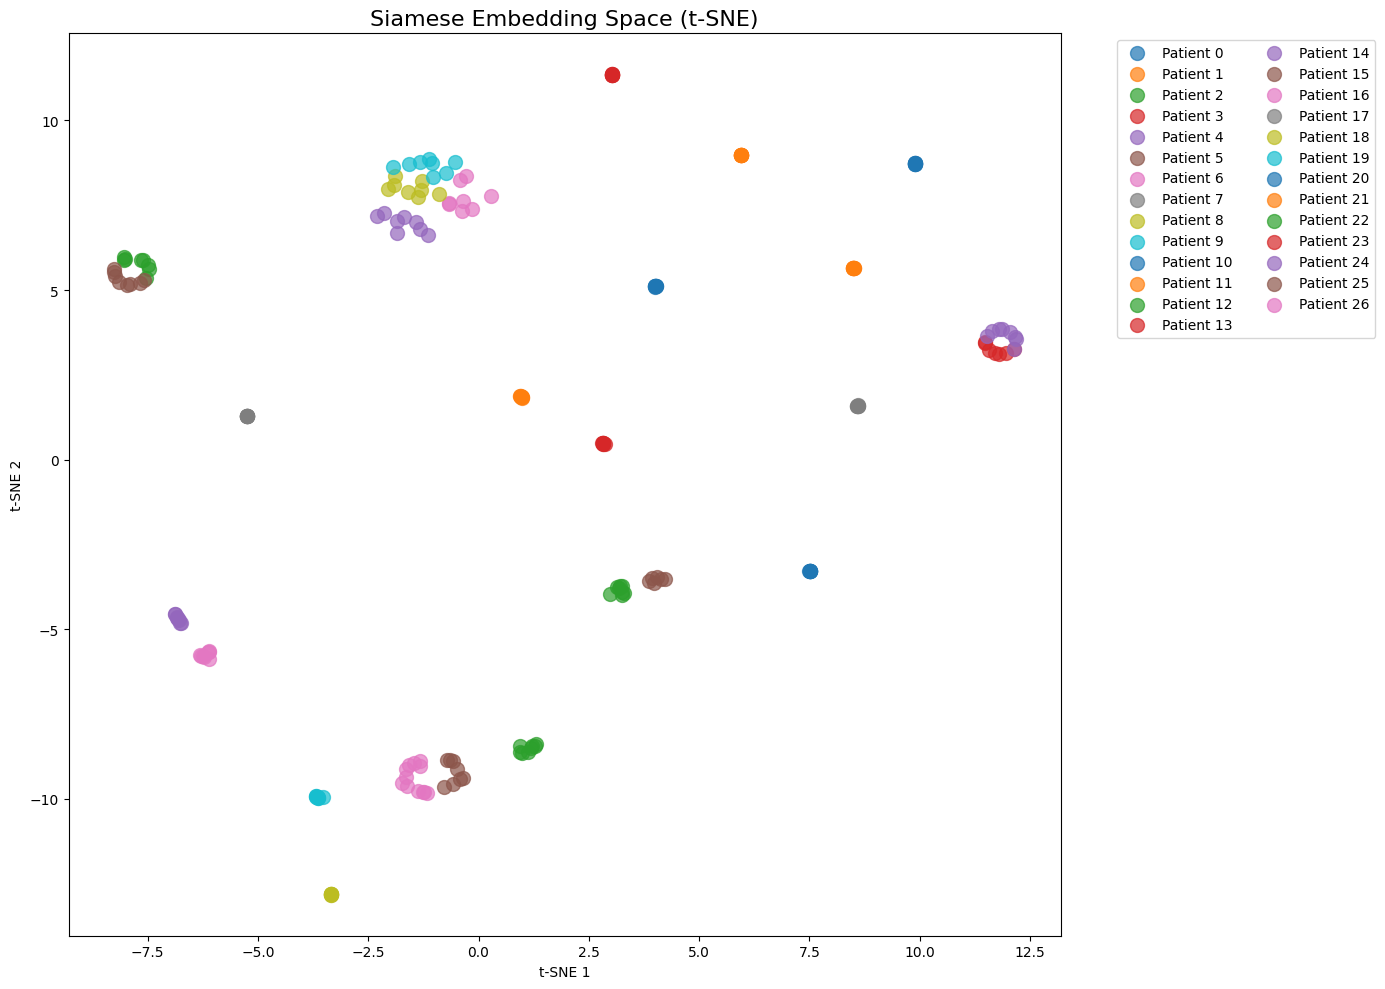

In [35]:
# t-SNE plot
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

Z = embedder_hybrid.predict(X)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
Z_2d = tsne.fit_transform(Z)

plt.figure(figsize=(14, 10))
for i, p in enumerate(np.unique(y)):
    idx = y == p
    plt.scatter(Z_2d[idx, 0], Z_2d[idx, 1], 
                label=f'Patient {p}', alpha=0.7, s=100)
plt.legend(bbox_to_anchor=(1.05, 1), ncol=2)
plt.title('Siamese Embedding Space (t-SNE)', fontsize=16)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.savefig('siamese_tsne.png', dpi=300)
plt.show()

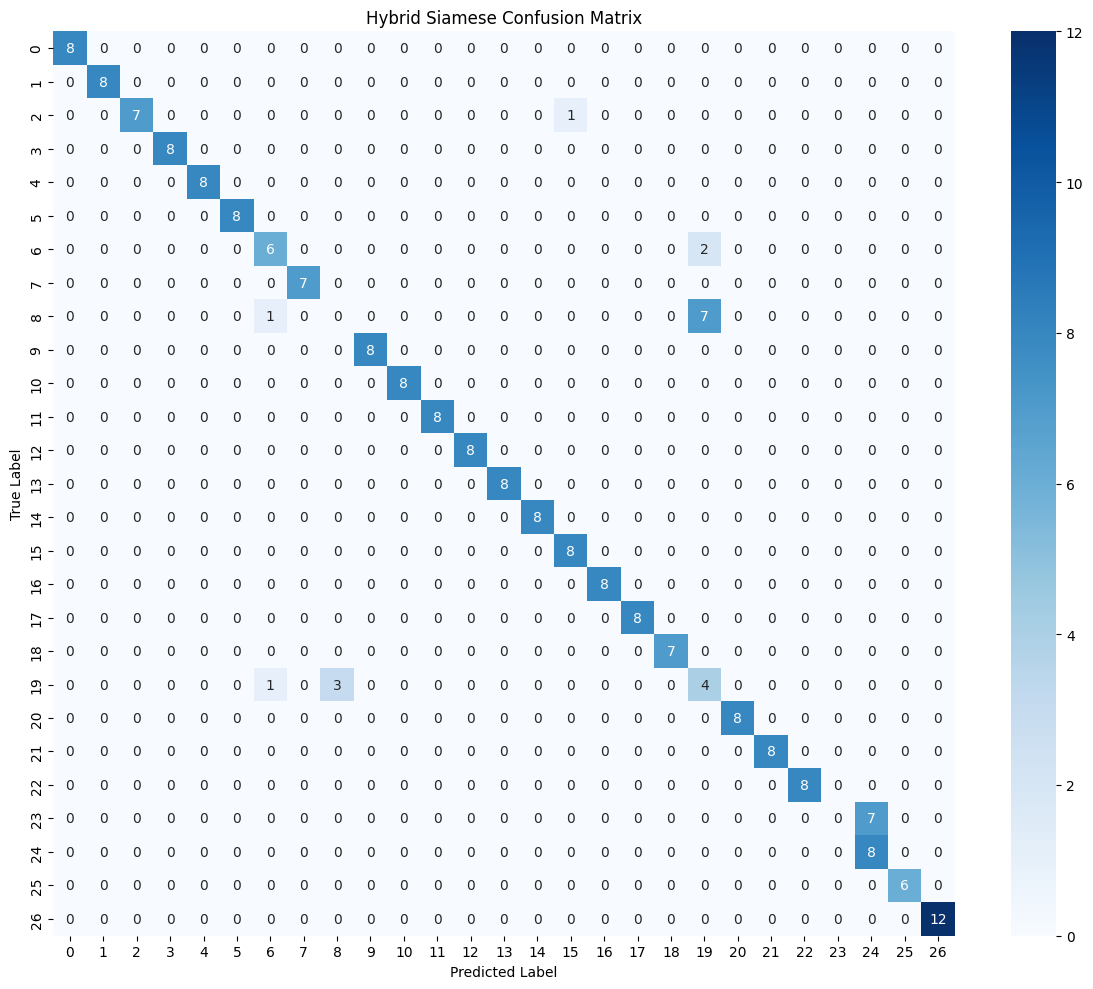

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true_hybrid, y_pred_hybrid)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Hybrid Siamese Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

In [34]:
# Hangi hastalar zor?
from sklearn.metrics import classification_report

report = classification_report(y_true_hybrid, y_pred_hybrid, 
                               output_dict=True, zero_division=0)
per_class = pd.DataFrame(report).T[:-3]  # Exclude avg rows
per_class = per_class.sort_values('f1-score')

print("En zor 5 hasta:")
print(per_class.head())

print("\nEn kolay 5 hasta:")
print(per_class.tail())

En zor 5 hasta:
    precision  recall  f1-score  support
8    0.000000    0.00  0.000000      8.0
23   0.000000    0.00  0.000000      7.0
19   0.307692    0.50  0.380952      8.0
24   0.533333    1.00  0.695652      8.0
6    0.750000    0.75  0.750000      8.0

En kolay 5 hasta:
    precision  recall  f1-score  support
21        1.0     1.0       1.0      8.0
16        1.0     1.0       1.0      8.0
22        1.0     1.0       1.0      8.0
25        1.0     1.0       1.0      6.0
26        1.0     1.0       1.0     12.0
